In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
!pip install transformers
!pip install transformers[sentencepiece]
!pip install datasets
!pip install gluonnlp
!pip install mxnet
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-0f2cdg4k/kobert-tokenizer_debf23f304644b49a3eb8eb6f0c20078
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-0f2cdg4k/kobert-tokenizer_debf23f304644b49a3eb8eb6f0c20078
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done


In [ ]:
# ! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
# %cd Mecab-ko-for-Google-Colab
# !bash install_mecab-ko_on_colab190912.sh

In [ ]:
# !bash install_mecab-ko_on_colab_light_220429.sh

# data preprocessing

In [1]:
# data directory
%cd /content/drive/Othercomputers/내 컴퓨터/GitHub/자연어 처리/명품 커머스 플렛폼 분석/Bert-VOC_e-commerce

/content/drive/Othercomputers/내 컴퓨터/GitHub/자연어 처리/명품 커머스 플렛폼 분석/Bert-VOC_e-commerce


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gluonnlp as nlp
from konlpy.tag import Mecab

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader

from transformers import pipeline
from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import BertModel
from datetime import datetime
from kobert_tokenizer import KoBERTTokenizer
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

import utils
from utils import save_model, load_model, c_load_model, calc_accuracy, softmax
from model import BERTDataset, BERTClassifier, c_BERTClassifier, EarlyStopping, senti_predict, category_predict
from preprocessing import senti_preprocessing, category_preprocessing

- 긍/부정

In [3]:
senti_data_dir = './data/'
senti_data, senti_raw = senti_preprocessing(senti_data_dir)
np.random.shuffle(senti_data)
senti_data[:5]

[['트렌비에서 제품 벌써 두번째인데 만족스런 소비했습니다! 트렌비에서 하는 출석 이벤트 열심히 참여했어요!', 1],
 ['정품 보장해주는 것도 크구욥', 1],
 ['요즘 스타일을 발란에서 배워요', 1],
 ['좋아요', 1],
 ['쿠폰 마니마니 주세용', 1]]

In [4]:
senti_raw.head()

,platform,store,date,review,rating,category,label
0,trenbe,apple,20230202.0,월일에 주문에서 월일에 재고가 없어 환불처리 됐다고 통보하네요,1.0,고객센터,0
1,trenbe,apple,20230202.0,어이가없어서 여기 믿고 물건 구매해서 안심하고 기다리다 뒤통수 맞고 다시 물건 찾는...,1.0,정품 안전성,0
2,trenbe,apple,20230202.0,기다려도 물건 안와요,1.0,배송,0
3,trenbe,google,20230201.0,여기 상품반품비로 먹고사는 업체인것같습니다,1.0,배송,0
4,trenbe,google,20230201.0,나쁜놈들,1.0,만족도&기타,0


In [5]:
senti_raw['label'].unique(), len(senti_raw)

(array([0, 1]), 13366)

In [6]:
senti_raw.groupby('label').size().reset_index(name='count')

,label,count
0,0,2484
1,1,10882


<Axes: >

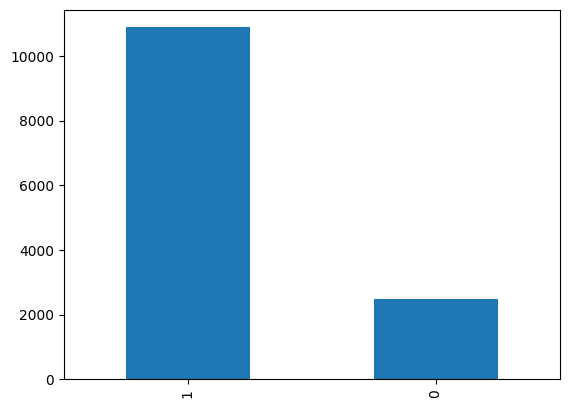

In [7]:
senti_raw['label'].value_counts().plot(kind='bar')

- category

In [8]:
category_data_dir = './data/'
category_data, category_raw = category_preprocessing(category_data_dir)
np.random.shuffle(category_data)
category_data[:5]

[['복잡한거 싫어하고 간편히 템사진들 보기 좋습니다', 1],
 ['앞으로도 잘 믿고 구매할게요', 7],
 ['다시 명품을 사게 되면 발란에서 살듯합니다', 8],
 ['나중에는 전화와서 누락된정보 물어보면서 내일 진짜 주문들어간다더니 4일지난 지금 알고보니 아직도 재고가없었음.. 안내도 거짓으로.. 너무화나서 씁니다 쓰지마세요',
  2],
 ['쿠폰팩 다양해서 좋은 것 같아요 웬만하면 거의 할인 받을 수 있네요', 5]]

In [9]:
CATE_TO_NUM = {
    '배송':0,
    'UX/UI 편의성':1,
    '고객센터':2,
    '상품 구색':3,
    '앱 오류':4,
    '가격&프로모션':5,
    '상품 품질':6,
    '정품 안전성':7,
    '만족도&기타':8,
    '상품 설명':9
}

In [10]:
category_raw['cate_label'].unique()

array([2, 7, 0, 8, 5, 9, 3, 6, 1, 4])

In [11]:
category_raw.groupby('cate_label').size().reset_index(name='count')

,cate_label,count
0,0,1034
1,1,1525
2,2,757
3,3,1436
4,4,738
5,5,2306
6,6,320
7,7,1141
8,8,3920
9,9,189


<Axes: >

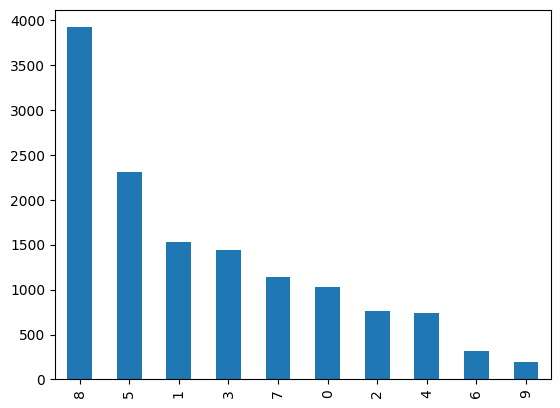

In [12]:
category_raw['cate_label'].value_counts().plot(kind='bar')

### max length 확인

In [11]:
mecab = Mecab()
max_len = []
for sentence in category_raw['review']:
    max_len.append(len(mecab.morphs(sentence)))

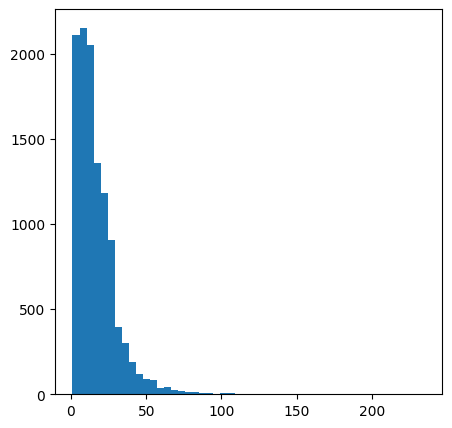

In [12]:
plt.figure(figsize=(5, 5))
plt.hist(max_len, bins=50)
plt.show()

# training

In [13]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower = False)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


## 긍/부정

In [18]:
# 긍/부정
num_classes = 2
senti_dataset_train, senti_dataset_test = train_test_split(senti_data, test_size = 0.2, shuffle = True, random_state = 32)

In [32]:
patience = 5
max_len = 128
batch_size = 64 ###
warmup_ratio = 0.1
num_epochs = 10 ###
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5 ### 0.001 - 0.005 - 0.0001
dr_rate = 0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [33]:
tok = tokenizer.tokenize

senti_data_train = BERTDataset(senti_dataset_train, 0, 1, tok, vocab, max_len, True, False)
senti_data_test = BERTDataset(senti_dataset_test, 0, 1, tok, vocab, max_len, True, False)

In [34]:
# train 토큰 최대 길이
to_len = [senti_data_train[idx][1].astype(int) for idx in range(len(senti_data_train))]
max(to_len)

array(128)

In [35]:
# test 토큰 최대 길이
to_len = [senti_data_test[idx][1].astype(int) for idx in range(len(senti_data_test))]
max(to_len)

array(128)

In [36]:
senti_train_dataloader = torch.utils.data.DataLoader(senti_data_train, batch_size = batch_size, num_workers = 5)
senti_test_dataloader = torch.utils.data.DataLoader(senti_data_test, batch_size = batch_size, num_workers = 5)

In [37]:
model = BERTClassifier(bertmodel, num_classes=num_classes, dr_rate=dr_rate).to(device)

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr = learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(senti_train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps = warmup_step, num_training_steps = t_total)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


- 학습


In [ ]:
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

for epoch in range(num_epochs):
    train_acc = 0.0
    val_acc = 0.0

    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(senti_train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule

        train_acc += calc_accuracy(out, label)

        t_acc = (train_acc / (batch_id+1))
        # train_accuracies.append(t_acc)
        # train_losses.append(loss.item())
        print(f'Train Acc: {t_acc:.4f}\t| Train Loss: {loss.item():.4f}')

    model.eval()
    with torch.no_grad():
        for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(senti_test_dataloader)):
            token_ids = token_ids.long().to(device)
            segment_ids = segment_ids.long().to(device)
            valid_length= valid_length
            label = label.long().to(device)

            out = model(token_ids, valid_length, segment_ids)
            val_loss = loss_fn(out, label)
            val_acc += calc_accuracy(out, label)

            v_acc = (val_acc / (batch_id+1))
            # val_accuracies.append(v_acc)
            # val_losses.append(val_loss.item())
            print(f'Val Acc: {t_acc:.4f}\t| Val Loss: {loss.item():.4f}')

    train_accuracies.append(t_acc)
    train_losses.append(loss.item())
    val_accuracies.append(v_acc)
    val_losses.append(val_loss.item())
    print(f'EPOCHS: {epoch+1}/{num_epochs}\t| train acc: {t_acc}\t| train loss: {loss.item()}\t| val acc: {v_acc}\t| val loss: {val_loss.item()}')


    # epoch 당 save
    if (epoch+1) % 5 == 0:
        save_model(model.state_dict(), f'senti_model_{epoch+1}.pth')

save_model(model.state_dict(), f'senti_model_{epoch+1}.pth')

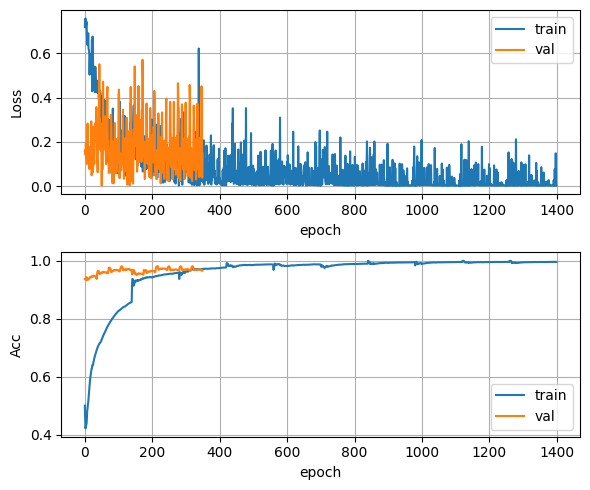

In [27]:
plt.figure(figsize=(6, 5))
plt.subplot(211)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.grid('on')
plt.legend()

plt.subplot(212)
plt.plot(train_accuracies, label='train')
plt.plot(val_accuracies, label='val')
plt.xlabel('epoch')
plt.ylabel('Acc')
plt.grid('on')
plt.legend()
plt.tight_layout()
plt.show()

## category


In [ ]:
patience = 10
max_len = 128
batch_size = 256 ## 256 - 512 (total : 14,000)
warmup_ratio = 0.1
num_epochs = 30 ## 30 - 100
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5 ## 0.001 -  0.001 / 0.0005 / 0.00001
dr_rate = 0.5    ## 0.5 or 0.45
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# category
num_classes = 10
category_dataset_train, category_dataset_test = train_test_split(category_data, test_size = 0.2, shuffle = True, random_state = 32)

In [ ]:
tok = tokenizer.tokenize

category_data_train = BERTDataset(category_dataset_train, 0, 1, tok, vocab, max_len, True, False)
category_data_test = BERTDataset(category_dataset_test, 0, 1, tok, vocab, max_len, True, False)

In [ ]:
category_train_dataloader = torch.utils.data.DataLoader(category_data_train, batch_size = batch_size)
category_test_dataloader = torch.utils.data.DataLoader(category_data_test, batch_size = batch_size)

In [ ]:
c_model = c_BERTClassifier(bertmodel, dr_rate=dr_rate).to(device)

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in c_model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in c_model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr = learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(category_train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps = warmup_step, num_training_steps = t_total)

- 학습


In [ ]:
c_train_accuracies = []
c_train_losses = []
c_val_accuracies = []
c_val_losses = []

for epoch in range(num_epochs):
    train_acc = 0.0
    val_acc = 0.0

    c_model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(category_train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)

        out = c_model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(c_model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule

        train_acc += calc_accuracy(out, label)

        t_acc = (train_acc / (batch_id+1))
        # c_train_accuracies.append(t_acc)
        # c_train_losses.append(loss.item())
        print(f'Train Acc: {t_acc:.4f}\t| Train Loss: {loss.item():.4f}')

    c_model.eval()
    with torch.no_grad():
        for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(category_test_dataloader)):
            token_ids = token_ids.long().to(device)
            segment_ids = segment_ids.long().to(device)
            valid_length= valid_length
            label = label.long().to(device)

            out = c_model(token_ids, valid_length, segment_ids)
            val_loss = loss_fn(out, label)
            val_acc += calc_accuracy(out, label)

            v_acc = (val_acc / (batch_id+1))
            # c_val_accuracies.append(v_acc)
            # c_val_losses.append(val_loss.item())
            print(f'Train Acc: {t_acc:.4f}\t| Train Loss: {loss.item():.4f}')

    c_train_accuracies.append(t_acc)
    c_train_losses.append(loss.item())
    c_val_accuracies.append(v_acc)
    c_val_losses.append(val_loss.item())
    print(f'EPOCHS: {epoch+1}/{num_epochs}\t| train acc: {t_acc}\t| train loss: {loss.item()}\t| val acc: {v_acc}\t| val loss: {val_loss.item()}')


    if (epoch+1) % 1 == 0:
        save_model(c_model.state_dict(), f'category_model_{epoch+1}.pth')

save_model(c_model.state_dict(), f'category_model_{epoch+1}.pth')

  0%|          | 0/26 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.0121804475784302 train acc 0.71875
epoch 1 train acc 0.6602564102564104


  0%|          | 0/7 [00:00<?, ?it/s]

epoch 1 test acc 0.6960403726708074


In [ ]:
plt.figure(figsize=(6, 5))
plt.subplot(211)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.grid('on')
plt.legend()

plt.subplot(212)
plt.plot(train_accuracies, label='train')
plt.plot(val_accuracies, label='val')
plt.xlabel('epoch')
plt.ylabel('Acc')
plt.grid('on')
plt.legend()
plt.tight_layout()
plt.show()

## Testing

- 긍/부정

In [ ]:
ls

config.py                          numti-label_classification.ipynb
data/                              prediction.py
exam/                              preprocessing.py
Kobert_multi_classification.ipynb  __pycache__/
metrics_for_multilabel.py          trained_model/
model.py                           utils.py


In [ ]:
senti_ckpt_path = './trained_model/senti_model_1.pth'

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE
senti_model = load_model(senti_ckpt_path, DEVICE)
senti_model

- category

In [ ]:
category_ckpt_path = './trained_model/category_model_1.pth'

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE
category_model = c_load_model(category_ckpt_path, DEVICE)
category_model

- 긍/부정


In [ ]:
index = 3

sentence = senti_test_dataloader[index][0]
print(sentence)
senti_predict(sentence)

믿음을주셨씀해요


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


문장에서 부정이 1.1% 만큼, 긍정이 97.8% 만큼, 애매모호함이 1.1% 만큼 보여집니다.


In [ ]:
for idx, sentence in enumerate(senti_test_dataloader):
    print(sentence)
    senti_predict(sentence[0])
    if idx == 10:
        break

- category

In [ ]:
def category_predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size = batch_size, num_workers = 5)

    c_model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length = valid_length
        label = label.long().to(device)

        out = c_model(token_ids, valid_length, segment_ids)

        test_eval = []
        i = out[0]
        logits = i.detach().cpu().numpy()
        logits = softmax(logits)
        for senti in logits:
            test_eval.append(round(senti*100, 1))

        print(test_eval)

In [ ]:
CATE_TO_NUM = {
    '배송':0,
    'UX/UI 편의성':1,
    '고객센터':2,
    '상품 구색':3,
    '앱 오류':4,
    '가격&프로모션':5,
    '상품 품질':6,
    '정품 안전성':7,
    '만족도&기타':8,
    '상품 설명':9
}

In [ ]:
index = 29

sentence = category_dataset_test[index][0]
print(sentence)
category_predict(sentence)

좋네여
[11.9, 12.1, 9.3, 9.4, 13.2, 7.4, 10.3, 8.5, 11.4, 6.7]


In [ ]:
for idx, sentence in enumerate(category_test_dataloader):
    print(sentence)
    category_predict(sentence[0])
    if idx == 10:
        break

['주문 취소건에 대해 전화도하고 채팅도 해봤지만아무 응답도 못받았습니다 머스트잇 발란에 비해 도태될거 같아요', 0]
문장에서 부정이 89.6% 만큼, 긍정이 3.8% 만큼, 애매모호함이 6.5% 만큼 보여집니다.
['옙 평가보고 설치만하고 바로 지움ㅋㅋㅋㅋㅋㅋㅋㅋ많은 사람들이 배송 및 환불 시스템에 관해 불만이 많은거 같은데 개선할 의지도 없어보이는듯', 0]
문장에서 부정이 89.0% 만큼, 긍정이 4.4% 만큼, 애매모호함이 6.6% 만큼 보여집니다.
['감사합니다', 1]
문장에서 부정이 3.1% 만큼, 긍정이 95.0% 만큼, 애매모호함이 1.9% 만큼 보여집니다.
['믿음을주셨씀해요', 0]
문장에서 부정이 1.1% 만큼, 긍정이 98.1% 만큼, 애매모호함이 0.8% 만큼 보여집니다.
['카카페 네페 결제 되는게 신의 한수 특히 카카페 즉시할인 이벤트 할때 사면 완전 개이득이쥬', 1]
문장에서 부정이 34.0% 만큼, 긍정이 60.6% 만큼, 애매모호함이 5.3% 만큼 보여집니다.
['짱', 1]
문장에서 부정이 0.9% 만큼, 긍정이 98.5% 만큼, 애매모호함이 0.6% 만큼 보여집니다.
['브랜드마다 사이즈가 달라서 사이즈 결정하기 어려워서 고객센터 문의했었는데 답도 빠르고 친절해서 좋았던 기억이 ㅎㅎ', 1]
문장에서 부정이 0.4% 만큼, 긍정이 99.2% 만큼, 애매모호함이 0.5% 만큼 보여집니다.
['아직까진 믿을만함', 1]
문장에서 부정이 0.5% 만큼, 긍정이 99.0% 만큼, 애매모호함이 0.5% 만큼 보여집니다.
['명품 사려고해도 백화점 발품팔기 힘든데 트렌비 하나면 다 보고 살수 있어서 좋은듯 ', 1]
문장에서 부정이 0.3% 만큼, 긍정이 99.2% 만큼, 애매모호함이 0.4% 만큼 보여집니다.
['사라는거야 말란거야 주문누르면 결제화면에 주문상품도안뜸 ㅋㅋ', 0]
문장에서 부정이 91.0% 만큼, 긍정이 2.6% 만큼, 애매모호함이 6.3% 만큼 보여집니다.
['좋습니다 직구의 불편함을 해결해주네요ㅎㅎ', 1]